# Instalação

In [1]:
!pip install trimesh
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 10.3 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
q1_dir = '/content/drive/My Drive/KITTI-Sequence'
q2_dir = '/content/drive/My Drive/img_dtlabs/post-processed'

Mounted at /content/drive


# Questão 1


## Depedencias

In [3]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import os
import random
import torch
import open3d as o3d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
q1_dir = '/content/drive/My Drive/KITTI-Sequence'

In [4]:
def extract_keypoints(points, num_keypoints):
    if points.shape[0] > num_keypoints:
        indices = np.random.choice(points.shape[0], num_keypoints, replace=False)
        return points[indices]
    return points

In [5]:
def remove_outliers(points, threshold=1.5):
    mean = np.mean(points, axis=0)
    dist = np.linalg.norm(points - mean, axis=1)
    return points[dist < threshold * np.std(dist)]


In [6]:
def load_point_cloud(file_path):
    mesh = trimesh.load(file_path)
    return np.array(mesh.vertices)

In [7]:
def voxel_downsample(points, voxel_size):
    voxel_grid = np.floor(points / voxel_size).astype(np.int32)
    unique_voxels, indices = np.unique(voxel_grid, axis=0, return_index=True)
    return points[indices]


In [8]:
def load_all_point_clouds(q1_dir):
    point_clouds = []

    for root, dirs, files in os.walk(q1_dir):
        for file in files:
            if file.endswith('.obj'):
                file_path = os.path.join(root, file)
                print(f"Carregando arquivo: {file_path}")
                point_cloud = load_point_cloud(file_path)
                point_clouds.append(point_cloud)

    return point_clouds

In [9]:
def closest_point(src, dst):
    distances = torch.cdist(src, dst)
    indices = torch.argmin(distances, dim=1)
    return indices


In [10]:
def estimate_rigid_transform(A, B):
    centroid_A = torch.mean(A, dim=0)
    centroid_B = torch.mean(B, dim=0)

    H = (A - centroid_A).T @ (B - centroid_B)
    U, S, Vt = torch.svd(H)
    R = Vt @ U.T

    if torch.det(R) < 0:
        Vt[:, -1] *= -1
        R = Vt @ U.T

    t = centroid_B - R @ centroid_A
    return R, t

In [11]:
def icp(src, dst, max_iterations=100, tolerance=1e-6):
    if src.shape[0] > dst.shape[0]:
        src = src[np.random.choice(src.shape[0], dst.shape[0], replace=False)]
    elif dst.shape[0] > src.shape[0]:
        dst = dst[np.random.choice(dst.shape[0], src.shape[0], replace=False)]

    src_homogeneous = np.ones((src.shape[0], 4))
    src_homogeneous[:, :-1] = src
    T = np.eye(4)
    prev_error = float('inf')

    for i in range(max_iterations):
        indices = closest_point(src_homogeneous[:, :-1], dst)
        matched_src = src_homogeneous[:, :-1][indices]

        R, t = estimate_rigid_transform(matched_src, dst)

        src_homogeneous[:, :-1] = (R @ src_homogeneous[:, :-1].T).T + t

        error = np.mean(np.linalg.norm(src_homogeneous[:, :-1] - dst, axis=1))
        if abs(prev_error - error) < tolerance:
            break
        prev_error = error

    return T


def icp_with_voxel(src, dst, max_iterations=200, tolerance=1e-6):
    src = voxel_downsample(src, 0.2)  # Ajuste o valor do voxel_size conforme necessário
    dst = voxel_downsample(dst, 0.2)

    # Garantir que as nuvens subamostradas tenham o mesmo número de pontos
    min_points = min(src.shape[0], dst.shape[0])
    src = src[:min_points]
    dst = dst[:min_points]

    src_homogeneous = np.ones((src.shape[0], 4))
    src_homogeneous[:, :-1] = src

    T = np.eye(4)
    prev_error = float('inf')

    # Construir a árvore KD apenas uma vez
    tree = KDTree(dst)

    for i in range(max_iterations):
        distances, indices = tree.query(src_homogeneous[:, :-1])

        # Corrigindo os índices para garantir que não ultrapassem o tamanho do array
        indices = np.clip(indices, 0, dst.shape[0] - 1)

        matched_src = src_homogeneous[:, :-1][indices]

        R, t = estimate_rigid_transform(matched_src, dst)

        src_homogeneous[:, :-1] = (R @ src_homogeneous[:, :-1].T).T + t

        error = np.mean(np.linalg.norm(src_homogeneous[:, :-1] - dst, axis=1))
        if abs(prev_error - error) < tolerance:
            break
        prev_error = error

    return T

def icp_torch(src, dst, max_iterations=500, tolerance=1e-6):

    #src = extract_keypoints(src, 500)  # Extrair 500 keypoints
    #dst = extract_keypoints(dst, 500)

    src = torch.tensor(src, dtype=torch.float32, device=device)
    dst = torch.tensor(dst, dtype=torch.float32, device=device)

    for i in range(max_iterations):
        indices = closest_point(src, dst)
        matched_dst = dst[indices]

        R, t = estimate_rigid_transform(src, matched_dst)
        src = (R @ src.T).T + t

        error = torch.mean(torch.norm(src - matched_dst, dim=1))
        if error < tolerance:
            break

        # Limpar a memória da GPU
        torch.cuda.empty_cache()

    return R.cpu().numpy(), t.cpu().numpy()

In [12]:
def estimate_trajectory(scans):
    trajectory = [np.eye(4)]
    for i in range(1, len(scans)):
        src = voxel_downsample(scans[i-1], 0.3)
        dst = voxel_downsample(scans[i], 0.3)

        R, t = icp_torch(src, dst)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        trajectory.append(trajectory[-1] @ T)
    return np.array(trajectory)

In [13]:
def compare_with_ground_truth(estimated_trajectory, ground_truth):
    error = np.linalg.norm(estimated_trajectory - ground_truth, axis=(1, 2))
    print("Erro médio: ", np.mean(error))
    return error

In [14]:
def plot_trajectory(trajectory):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = trajectory[:, 0, 3]
    y = trajectory[:, 1, 3]
    z = trajectory[:, 2, 3]

    ax.plot(x, y, z, label='Trajectory')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Comparar com a Implementacao usual

In [15]:
def calculate_ground_truth_trajectory(scans):
    trajectory = [np.eye(4)]  # Começa com a identidade

    pcd_prev = o3d.geometry.PointCloud()
    pcd_prev.points = o3d.utility.Vector3dVector(scans[0])

    for i in range(1, len(scans)):
        pcd_curr = o3d.geometry.PointCloud()
        pcd_curr.points = o3d.utility.Vector3dVector(scans[i])

        reg_icp = o3d.pipelines.registration.registration_icp(
            pcd_curr, pcd_prev,
            max_correspondence_distance=0.2,
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )

        T = reg_icp.transformation
        trajectory.append(trajectory[-1] @ T)

        pcd_prev = pcd_curr

    return np.array(trajectory)


In [16]:
def plot_comparison(estimated, reference):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Trajetória estimada
    ax.plot(estimated[:, 0, 3], estimated[:, 1, 3], estimated[:, 2, 3], label='Trajectory Estimada', color='blue')

    # Trajetória de referência
    ax.plot(reference[:, 0, 3], reference[:, 1, 3], reference[:, 2, 3], label='Trajectory de Referência', color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

In [17]:
def compare_trajectories(estimated, reference):
    error = np.linalg.norm(estimated - reference, axis=(1, 2))
    mean_error = np.mean(error)
    print("Erro médio em comparação com a open3D: ", mean_error)
    return error

## Resposta da Questão 1

Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000002/000002_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000010/000010_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000019/000019_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000017/000017_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000021/000021_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000026/000026_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000004/000004_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000005/000005_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000028/000028_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000003/000003_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000027/000027_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000011/000011_poi

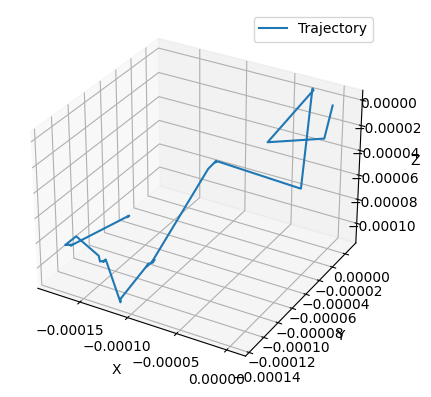

In [18]:
ground_truth = np.load('/content/drive/My Drive/ground_truth.npy')
scans = load_all_point_clouds(q1_dir)
estimated_trajectory = estimate_trajectory(scans)
compare_with_ground_truth(estimated_trajectory, ground_truth)
plot_trajectory(estimated_trajectory)

## Comparativo com Implementação existente

Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000002/000002_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000010/000010_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000019/000019_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000017/000017_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000021/000021_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000026/000026_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000004/000004_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000005/000005_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000028/000028_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000003/000003_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000027/000027_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000011/000011_poi

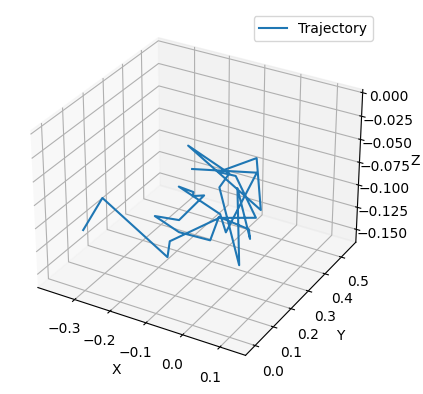

In [19]:
ground_truth = np.load('/content/drive/My Drive/ground_truth.npy')
scans = load_all_point_clouds(q1_dir)
reference_trajectory = calculate_ground_truth_trajectory(scans)
compare_with_ground_truth(reference_trajectory, ground_truth)
plot_trajectory(reference_trajectory)

# Questão 2

# Dependencias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pickle
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Configurações
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
q2_dir = '/content/drive/My Drive/img_dtlabs/post-processed'

# Transformações
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Carregar dataset
dataset = datasets.ImageFolder(q2_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

num_classes = len(dataset.classes)
print(f'Número de classes: {num_classes}')

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = None
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(F.selu(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.selu(self.conv4(x)))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.selu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


def calculate_fc_input_size(model, input_size=(3, 64, 64)):
    with torch.no_grad():
        input_tensor = torch.randn(1, *input_size).to(device)
        x = F.selu(model.conv1(input_tensor))
        x = model.pool(x)
        x = F.tanh(model.conv2(x))
        x = model.pool(x)
        x = F.leaky_relu(model.conv3(x))
        x = model.pool(x)
        x = F.selu(model.conv4(x))
        x = model.pool(x)
        return x.view(1, -1).size(1)

# Instanciar modelo com o número de classes
model = CNN(num_classes).to(device)

# Calcular o tamanho correto de entrada para a camada fc1
fc_input_size = calculate_fc_input_size(model)
print(f"Tamanho correto para fc1: {fc_input_size}")

# Atualizar a camada fc1 com o tamanho correto
model.fc1 = nn.Linear(fc_input_size,32).to(device)


Número de classes: 2996
Tamanho correto para fc1: 512


In [3]:
# Configurações de treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Acurácia: {accuracy:.4f}%')



KeyboardInterrupt: 

In [ ]:
def extract_descriptors(model, dataloader):
    model.eval()
    descriptors = []
    labels_list = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            descriptors.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    return np.concatenate(descriptors), np.concatenate(labels_list)

# Extraindo descritores
descriptors, labels = extract_descriptors(model, dataloader)
save_path = '/content/drive/My Drive/descriptors.pkl'

# Salvando o arquivo no Google Drive
with open(save_path, 'wb') as f:
    pickle.dump((descriptors, labels), f)

print(f'Arquivo salvo em: {save_path}')

In [ ]:
model_path = '/content/drive/My Drive/descriptors.pkl'

new_image = Image.open('/content/drive/My Drive/marcelinho_no_db.jpg')
new_image = transform(new_image).unsqueeze(0).to(device)

# Extrair descritor
model.eval()
with torch.no_grad():
    new_descriptor = model(new_image).cpu().numpy()

# Adicionar ao banco de dados
descriptors = np.append(descriptors, new_descriptor, axis=0)

# Atualizar banco de dados
with open(model_path, 'wb') as f:
    pickle.dump((descriptors, labels), f)


In [ ]:
model_path = '/content/drive/My Drive/descriptors.pkl'

with open(model_path, 'rb') as f:
    descriptors, labels = pickle.load(f)

# Calcular similaridade
similarity_scores = cosine_similarity(new_descriptor, descriptors)
best_match_index = np.argmax(similarity_scores)
best_score = similarity_scores[0][best_match_index]

# Exibir resultados
print(f'Best match index: {best_match_index}, Score: {best_score}')
print(f'Identified as: {labels[best_match_index]}')

# Exibir a imagem
plt.imshow(new_image.cpu().permute(1, 2, 0))
plt.title(f'Match Score: {best_score:.2f}')
plt.axis('off')
plt.show()
